In [1]:
# Import necessary libraries
import scanpy as sc
from sklearn.linear_model import LogisticRegressionCV
from scipy.stats.contingency import crosstab
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import scipy.sparse as sp
import numpy as np
import pandas as pd

In [ ]:
# Load the datasets
path_file = '8_Classifiers/Data/Input/adata_myeloid.h5ad'

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 182934 × 10
    obs: 'UMAP1', 'UMAP2', 'leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4', 'cell_type', 'louvain_None', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'myeloid_cell_type', 'myeloid_louvain_None', 'myeloid_louvain_0.4', 'myeloid_louvain_0.6', 'myeloid_louvain_1.0', 'myeloid_louvain_1.4', 'myeloid_louvain_1.6', 'myeloid_louvain_1.8', 'myeloid_louvain_2.0', 'myeloid_louvain_1.2', 'predicted_type_1.0', 'predicted_type_1.2', 'predicted_type_1.4', 'predicted_type_1.6', 'predicted_type_1.8', 'predicted_type_2.0'
    var: 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'log1p', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'louvain_None', 'myeloid_cell_type_colors', 'myeloid_louvain_0.4', 'myeloid_louvain_0.4_colors', 'myeloid_louvain_0.6', 'myeloid_louvain_0.6_colors',

In [3]:
# Set X and Y
X = adata.X
Y = adata.obs['myeloid_cell_type']

In [ ]:
# Save the indices to later use the classifer with the actual labels and be able to save the predictions in adata
# Create an array of indices for all cells
all_indices = np.arange(X.shape[0])

# Split indices, keeping track of which are train/test
train_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.1,
    stratify=Y,
    random_state=42)

# Use indices to subset X and Y
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]

/tmp/ipykernel_3767427/1870435252.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_train, Y_test = Y[train_idx], Y[test_idx]


In [4]:
# Split into traiing and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=42)

In [ ]:
print('Original class distribution:\n', pd.Series(Y).value_counts(normalize=True))
print('\nTraining class distribution:\n', pd.Series(Y_train).value_counts(normalize=True))
print('\nTraining class counts:\n', pd.Series(Y_train).value_counts())

Original class distribution:
 myeloid_cell_type
Macrophages    0.880301
Monocytes      0.064083
Rest           0.029978
Neutrophils    0.018652
DCs            0.006937
Mast Cells     0.000049
Name: proportion, dtype: float64

Training class distribution:
 myeloid_cell_type
Macrophages    0.880302
Monocytes      0.064085
Rest           0.029974
Neutrophils    0.018653
DCs            0.006936
Mast Cells     0.000049
Name: proportion, dtype: float64

Training class counts:
 myeloid_cell_type
Macrophages    144933
Monocytes       10551
Rest             4935
Neutrophils      3071
DCs              1142
Mast Cells          8
Name: count, dtype: int64


In [ ]:
clf = LogisticRegressionCV(
    Cs=10,                          # Try 10 different values for C
    cv=10,                          # 10-fold cross-validation
    penalty='l2',                   # or 'elasticnet' if using l1_ratio
    solver='saga',                  # saga handles elasticnet and multiclass
    multi_class='multinomial',     # For softmax/multiclass setup
    scoring='accuracy',            # Scoring metric for CV
    max_iter=1000,                 # More iterations for convergence
    n_jobs=-1,                     # Parallel computation
    random_state=42,
    verbose=1)                      # Optional: helps debug convergence

# Fit the model
clf.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='weighted')

print(f"\nBest C values per class:\n{clf.C_}")
print(f"Accuracy on test set: {acc:.3f}")
print(f"F1 score on test set: {f1:.3f}")
print('\nClassification Report:\n', classification_report(Y_test, Y_pred))

# Save model
joblib.dump(clf, '8_Classifiers/Models/best_lr_model.pkl')

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


rescaling...
Epoch 1, change: 1.00000000
rescaling...
Epoch 2, change: 0.08383111
rescaling...
Epoch 3, change: 0.05425958
rescaling...
Epoch 4, change: 0.02383797
rescaling...
Epoch 5, change: 0.01570835
rescaling...
Epoch 6, change: 0.01399058
rescaling...
Epoch 7, change: 0.00885514
rescaling...
Epoch 8, change: 0.00698300
rescaling...
Epoch 9, change: 0.00193882
rescaling...
Epoch 10, change: 0.00219396
rescaling...
Epoch 11, change: 0.00151413
rescaling...
Epoch 12, change: 0.00064976
rescaling...
Epoch 13, change: 0.00061011
rescaling...
Epoch 14, change: 0.00045202
rescaling...
Epoch 15, change: 0.00043209
rescaling...
Epoch 16, change: 0.00042334
rescaling...
Epoch 17, change: 0.00037188
rescaling...
Epoch 18, change: 0.00056317
rescaling...
Epoch 19, change: 0.00040701
rescaling...
Epoch 20, change: 0.00052094
rescaling...
Epoch 21, change: 0.00035336
rescaling...
Epoch 22, change: 0.00047356
rescaling...
Epoch 23, change: 0.00036298
rescaling...
Epoch 24, change: 0.00046541
r

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 2, change: 0.00040074
Epoch 3, change: 0.00040061
Epoch 4, change: 0.00040093
Epoch 5, change: 0.00039963
Epoch 6, change: 0.00039970
Epoch 7, change: 0.00039837
Epoch 8, change: 0.00039707
Epoch 9, change: 0.00039687
Epoch 10, change: 0.00039874
Epoch 11, change: 0.00039599
Epoch 12, change: 0.00039652
Epoch 13, change: 0.00039605
Epoch 14, change: 0.00039530
Epoch 15, change: 0.00039328
Epoch 16, change: 0.00039488
Epoch 17, change: 0.00039344
Epoch 18, change: 0.00039333
Epoch 19, change: 0.00039286
Epoch 20, change: 0.00039138
Epoch 21, change: 0.00039176
Epoch 22, change: 0.00039132
Epoch 23, change: 0.00039142
Epoch 24, change: 0.00039024
Epoch 25, change: 0.00038937
Epoch 26, change: 0.00038936
Epoch 27, change: 0.00038931
Epoch 28, change: 0.00038862
Epoch 29, change: 0.00038664
Epoch 30, change: 0.00038813
Epoch 31, change: 0.00038606
Epoch 32, change: 0.00038707
Epoch 33, change: 0.00038645
Epoch 34, change: 0.00038473
Epoch 35, change: 0.00038538
Epoch 36, change: 0.00

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 1, change: 1.00000000
Epoch 2, change: 0.00039949
Epoch 3, change: 0.00040010
Epoch 4, change: 0.00039918
Epoch 5, change: 0.00039841
Epoch 6, change: 0.00039883
Epoch 7, change: 0.00039717
Epoch 8, change: 0.00039610
Epoch 9, change: 0.00039608
Epoch 10, change: 0.00039708
Epoch 11, change: 0.00039489
Epoch 12, change: 0.00039533
Epoch 13, change: 0.00039495
Epoch 14, change: 0.00039388
Epoch 15, change: 0.00039227
Epoch 16, change: 0.00039385
Epoch 17, change: 0.00039210
Epoch 18, change: 0.00039194
Epoch 19, change: 0.00039236
Epoch 20, change: 0.00038983
Epoch 21, change: 0.00039108
Epoch 22, change: 0.00038976
Epoch 23, change: 0.00039007
Epoch 24, change: 0.00038936
Epoch 25, change: 0.00038844
Epoch 26, change: 0.00038820
Epoch 27, change: 0.00038794
Epoch 28, change: 0.00038733
Epoch 29, change: 0.00038558
Epoch 30, change: 0.00038675
Epoch 31, change: 0.00038519
Epoch 32, change: 0.00038559
Epoch 33, change: 0.00038553
Epoch 34, change: 0.00038367
Epoch 35, change: 0.000

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 3, change: 0.00039905
Epoch 4, change: 0.00039816
Epoch 5, change: 0.00039734
Epoch 6, change: 0.00039761
Epoch 7, change: 0.00039654
Epoch 8, change: 0.00039548
Epoch 9, change: 0.00039493
Epoch 10, change: 0.00039541
Epoch 11, change: 0.00039414
Epoch 12, change: 0.00039398
Epoch 13, change: 0.00039412
Epoch 14, change: 0.00039303
Epoch 15, change: 0.00039121
Epoch 16, change: 0.00039273
Epoch 17, change: 0.00039116
Epoch 18, change: 0.00039132
Epoch 19, change: 0.00039099
Epoch 20, change: 0.00038858
Epoch 21, change: 0.00039039
Epoch 22, change: 0.00038828
Epoch 23, change: 0.00038888
Epoch 24, change: 0.00038843
Epoch 25, change: 0.00038815
Epoch 26, change: 0.00038619
Epoch 27, change: 0.00038740
Epoch 28, change: 0.00038567
Epoch 29, change: 0.00038501
Epoch 30, change: 0.00038521
Epoch 31, change: 0.00038487
Epoch 32, change: 0.00038409
Epoch 33, change: 0.00038450
Epoch 34, change: 0.00038253
Epoch 35, change: 0.00038329
Epoch 36, change: 0.00038205
Epoch 37, change: 0.0

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 2, change: 0.00039950
Epoch 3, change: 0.00039973
Epoch 4, change: 0.00039931
Epoch 5, change: 0.00039791
Epoch 6, change: 0.00039775
Epoch 7, change: 0.00039760
Epoch 8, change: 0.00039632
Epoch 9, change: 0.00039617
Epoch 10, change: 0.00039589
Epoch 11, change: 0.00039534
Epoch 12, change: 0.00039499
Epoch 13, change: 0.00039476
Epoch 14, change: 0.00039403
Epoch 15, change: 0.00039323
Epoch 16, change: 0.00039360
Epoch 17, change: 0.00039264
Epoch 18, change: 0.00039207
Epoch 19, change: 0.00039132
Epoch 20, change: 0.00039026
Epoch 21, change: 0.00039032
Epoch 22, change: 0.00038997
Epoch 23, change: 0.00038962
Epoch 24, change: 0.00038966
Epoch 25, change: 0.00038864
Epoch 26, change: 0.00038813
Epoch 27, change: 0.00038753
Epoch 28, change: 0.00038671
Epoch 29, change: 0.00038594
Epoch 30, change: 0.00038688
Epoch 31, change: 0.00038591
Epoch 32, change: 0.00038491
Epoch 33, change: 0.00038516
Epoch 34, change: 0.00038399
Epoch 35, change: 0.00038371
Epoch 36, change: 0.00

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 2, change: 0.00039797
Epoch 3, change: 0.00039867
Epoch 4, change: 0.00039841
Epoch 5, change: 0.00039700
Epoch 6, change: 0.00039748
Epoch 7, change: 0.00039655
Epoch 8, change: 0.00039552
Epoch 9, change: 0.00039527
Epoch 10, change: 0.00039473
Epoch 11, change: 0.00039439
Epoch 12, change: 0.00039389
Epoch 13, change: 0.00039399
Epoch 14, change: 0.00039318
Epoch 15, change: 0.00039131
Epoch 16, change: 0.00039242
Epoch 17, change: 0.00039140
Epoch 18, change: 0.00039085
Epoch 19, change: 0.00039073
Epoch 20, change: 0.00038934
Epoch 21, change: 0.00038918
Epoch 22, change: 0.00038859
Epoch 23, change: 0.00038951
Epoch 24, change: 0.00038844
Epoch 25, change: 0.00038695
Epoch 26, change: 0.00038721
Epoch 27, change: 0.00038678
Epoch 28, change: 0.00038569
Epoch 29, change: 0.00038480
Epoch 30, change: 0.00038604
Epoch 31, change: 0.00038489
Epoch 32, change: 0.00038298
Epoch 33, change: 0.00038491
Epoch 34, change: 0.00038272
Epoch 35, change: 0.00038266
Epoch 36, change: 0.00

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 2, change: 0.00040005
Epoch 3, change: 0.00040027
Epoch 4, change: 0.00040014
Epoch 5, change: 0.00039881
Epoch 6, change: 0.00039861
Epoch 7, change: 0.00039814
Epoch 8, change: 0.00039762
Epoch 9, change: 0.00039650
Epoch 10, change: 0.00039696
Epoch 11, change: 0.00039570
Epoch 12, change: 0.00039573
Epoch 13, change: 0.00039506
Epoch 14, change: 0.00039451
Epoch 15, change: 0.00039363
Epoch 16, change: 0.00039355
Epoch 17, change: 0.00039317
Epoch 18, change: 0.00039280
Epoch 19, change: 0.00039183
Epoch 20, change: 0.00039075
Epoch 21, change: 0.00039153
Epoch 22, change: 0.00039063
Epoch 23, change: 0.00039115
Epoch 24, change: 0.00038903
Epoch 25, change: 0.00038896
Epoch 26, change: 0.00038918
Epoch 27, change: 0.00038828
Epoch 28, change: 0.00038769
Epoch 29, change: 0.00038670
Epoch 30, change: 0.00038690
Epoch 31, change: 0.00038617
Epoch 32, change: 0.00038633
Epoch 33, change: 0.00038501
Epoch 34, change: 0.00038513
Epoch 35, change: 0.00038438
Epoch 36, change: 0.00

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 1, change: 1.00000000
Epoch 2, change: 0.00040107
Epoch 3, change: 0.00040088
Epoch 4, change: 0.00040088
Epoch 5, change: 0.00039998
Epoch 6, change: 0.00039932
Epoch 7, change: 0.00039880
Epoch 8, change: 0.00039821
Epoch 9, change: 0.00039789
Epoch 10, change: 0.00039684
Epoch 11, change: 0.00039709
Epoch 12, change: 0.00039613
Epoch 13, change: 0.00039593
Epoch 14, change: 0.00039517
Epoch 15, change: 0.00039506
Epoch 16, change: 0.00039476
Epoch 17, change: 0.00039406
Epoch 18, change: 0.00039290
Epoch 19, change: 0.00039279
Epoch 20, change: 0.00039195
Epoch 21, change: 0.00039212
Epoch 22, change: 0.00039190
Epoch 23, change: 0.00039173
Epoch 24, change: 0.00038993
Epoch 25, change: 0.00039022
Epoch 26, change: 0.00038963
Epoch 27, change: 0.00038898
Epoch 28, change: 0.00038895
Epoch 29, change: 0.00038781
Epoch 30, change: 0.00038773
Epoch 31, change: 0.00038709
Epoch 32, change: 0.00038688
Epoch 33, change: 0.00038588
Epoch 34, change: 0.00038595
Epoch 35, change: 0.000

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 3, change: 0.00039997
Epoch 4, change: 0.00039897
Epoch 5, change: 0.00039860
Epoch 6, change: 0.00039769
Epoch 7, change: 0.00039818
Epoch 8, change: 0.00039737
Epoch 9, change: 0.00039644
Epoch 10, change: 0.00039531
Epoch 11, change: 0.00039694
Epoch 12, change: 0.00039474
Epoch 13, change: 0.00039404
Epoch 14, change: 0.00039431
Epoch 15, change: 0.00039350
Epoch 16, change: 0.00039405
Epoch 17, change: 0.00039256
Epoch 18, change: 0.00039184
Epoch 19, change: 0.00039204
Epoch 20, change: 0.00039032
Epoch 21, change: 0.00039191
Epoch 22, change: 0.00039074
Epoch 23, change: 0.00039001
Epoch 24, change: 0.00038926
Epoch 25, change: 0.00038871
Epoch 26, change: 0.00038829
Epoch 27, change: 0.00038764
Epoch 28, change: 0.00038787
Epoch 29, change: 0.00038650
Epoch 30, change: 0.00038680
Epoch 31, change: 0.00038626
Epoch 32, change: 0.00038532
Epoch 33, change: 0.00038482
Epoch 34, change: 0.00038492
Epoch 35, change: 0.00038365
Epoch 36, change: 0.00038367
Epoch 37, change: 0.0

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 2, change: 0.00040085
Epoch 3, change: 0.00040102
Epoch 4, change: 0.00039967
Epoch 5, change: 0.00040001
Epoch 6, change: 0.00039845
Epoch 7, change: 0.00039941
Epoch 8, change: 0.00039827
Epoch 9, change: 0.00039757
Epoch 10, change: 0.00039612
Epoch 11, change: 0.00039701
Epoch 12, change: 0.00039653
Epoch 13, change: 0.00039506
Epoch 14, change: 0.00039480
Epoch 15, change: 0.00039491
Epoch 16, change: 0.00039455
Epoch 17, change: 0.00039367
Epoch 18, change: 0.00039276
Epoch 19, change: 0.00039253
Epoch 20, change: 0.00039175
Epoch 21, change: 0.00039197
Epoch 22, change: 0.00039166
Epoch 23, change: 0.00039057
Epoch 24, change: 0.00039011
Epoch 25, change: 0.00038911
Epoch 26, change: 0.00038968
Epoch 27, change: 0.00038909
Epoch 28, change: 0.00038860
Epoch 29, change: 0.00038682
Epoch 30, change: 0.00038772
Epoch 31, change: 0.00038706
Epoch 32, change: 0.00038636
Epoch 33, change: 0.00038593
Epoch 34, change: 0.00038588
Epoch 35, change: 0.00038456
Epoch 36, change: 0.00

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 3, change: 0.00039967
Epoch 4, change: 0.00039864
Epoch 5, change: 0.00039901
Epoch 6, change: 0.00039778
Epoch 7, change: 0.00039768
Epoch 8, change: 0.00039796
Epoch 9, change: 0.00039629
Epoch 10, change: 0.00039567
Epoch 11, change: 0.00039574
Epoch 12, change: 0.00039538
Epoch 13, change: 0.00039384
Epoch 14, change: 0.00039428
Epoch 15, change: 0.00039389
Epoch 16, change: 0.00039353
Epoch 17, change: 0.00039196
Epoch 18, change: 0.00039232
Epoch 19, change: 0.00039192
Epoch 20, change: 0.00039087
Epoch 21, change: 0.00039067
Epoch 22, change: 0.00039055
Epoch 23, change: 0.00038977
Epoch 24, change: 0.00038902
Epoch 25, change: 0.00038878
Epoch 26, change: 0.00038797
Epoch 27, change: 0.00038813
Epoch 28, change: 0.00038756
Epoch 29, change: 0.00038582
Epoch 30, change: 0.00038685
Epoch 31, change: 0.00038576
Epoch 32, change: 0.00038530
Epoch 33, change: 0.00038580
Epoch 34, change: 0.00038392
Epoch 35, change: 0.00038355
Epoch 36, change: 0.00038406
Epoch 37, change: 0.0

['../TestClassifiers/best_lr_model.pkl']

# Notes
+ The smallest class only has 8 samples: rerun with 8-fold cross validation

In [ ]:
# Load the best LR classifier
clf = joblib.load('8_Classifiers/Models/best_lr_model.pkl')

In [7]:
# Predict
Y_pred = clf.predict(X[test_idx])
Y_test = Y[test_idx]

/tmp/ipykernel_3767427/4114242244.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_test = Y[test_idx]


In [13]:
# Get obs_names (row labels) for test set
test_obs_names = adata.obs_names[test_idx]

# Assign NaNs first
adata.obs['lr_predicted_cell_type'] = np.nan

# Now assign predictions using aligned obs_names
adata.obs.loc[test_obs_names, 'lr_predicted_cell_type'] = Y_pred

/tmp/ipykernel_3767427/3128949728.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Macrophages' 'Macrophages' 'Macrophages' ... 'Macrophages' 'DCs'
 'Macrophages']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[test_obs_names, 'lr_predicted_cell_type'] = Y_pred


In [ ]:
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='weighted')

print(f"Accuracy on test set: {acc:.3f}")
print(f"F1 score on test set: {f1:.3f}")
print('\nClassification Report:\n', classification_report(Y_test, Y_pred))

Accuracy on test set: 0.999
F1 score on test set: 0.999

Classification Report:
               precision    recall  f1-score   support

         DCs       1.00      1.00      1.00       127
 Macrophages       1.00      1.00      1.00     16104
  Mast Cells       1.00      1.00      1.00         1
   Monocytes       1.00      1.00      1.00      1172
 Neutrophils       1.00      1.00      1.00       341
        Rest       1.00      0.99      0.99       549

    accuracy                           1.00     18294
   macro avg       1.00      1.00      1.00     18294
weighted avg       1.00      1.00      1.00     18294



In [ ]:
adata.write_h5ad('8_Classifiers/Data/Input/pred_adata_myeloid_.h5ad')

In [ ]:
# Load the datasets
path_file = '8_Classifiers/Data/Input/pred_adata_myeloid_.h5ad'

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 182934 × 10
    obs: 'UMAP1', 'UMAP2', 'leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4', 'cell_type', 'louvain_None', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'myeloid_cell_type', 'myeloid_louvain_None', 'myeloid_louvain_0.4', 'myeloid_louvain_0.6', 'myeloid_louvain_1.0', 'myeloid_louvain_1.4', 'myeloid_louvain_1.6', 'myeloid_louvain_1.8', 'myeloid_louvain_2.0', 'myeloid_louvain_1.2', 'predicted_type_1.0', 'predicted_type_1.2', 'predicted_type_1.4', 'predicted_type_1.6', 'predicted_type_1.8', 'predicted_type_2.0', 'rf_predicted_cell_type', 'lr_predicted_cell_type'
    var: 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'log1p', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'louvain_None', 'myeloid_cell_type_colors', 'myeloid_louvain_0.4', 'myeloid_louvain_0.4_colors', 

In [16]:
# Plot the results with only the predicted cell types and not the NaNs
# Select only rows where prediction is not NaN
mask = adata.obs['lr_predicted_cell_type'].notna()

# Extract true and predicted labels for test cells
true_labels = adata.obs.loc[mask, 'myeloid_cell_type']
pred_labels = adata.obs.loc[mask, 'lr_predicted_cell_type']

In [17]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[  127     0     0     0     0     0]
 [    0 16104     0     0     0     0]
 [    0     0     1     0     0     0]
 [    0     3     0  1169     0     0]
 [    0     0     0     0   341     0]
 [    0     7     0     0     0   542]]
              precision    recall  f1-score   support

         DCs       1.00      1.00      1.00       127
 Macrophages       1.00      1.00      1.00     16104
  Mast Cells       1.00      1.00      1.00         1
   Monocytes       1.00      1.00      1.00      1172
 Neutrophils       1.00      1.00      1.00       341
        Rest       1.00      0.99      0.99       549

    accuracy                           1.00     18294
   macro avg       1.00      1.00      1.00     18294
weighted avg       1.00      1.00      1.00     18294



<Axes: >

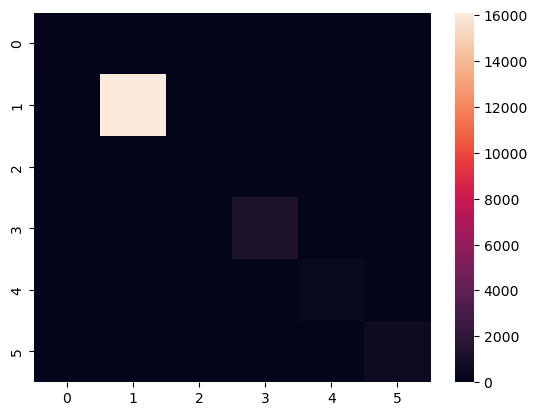

In [18]:
sns.heatmap(crosstab(list(true_labels.values), list(pred_labels.values)).count)

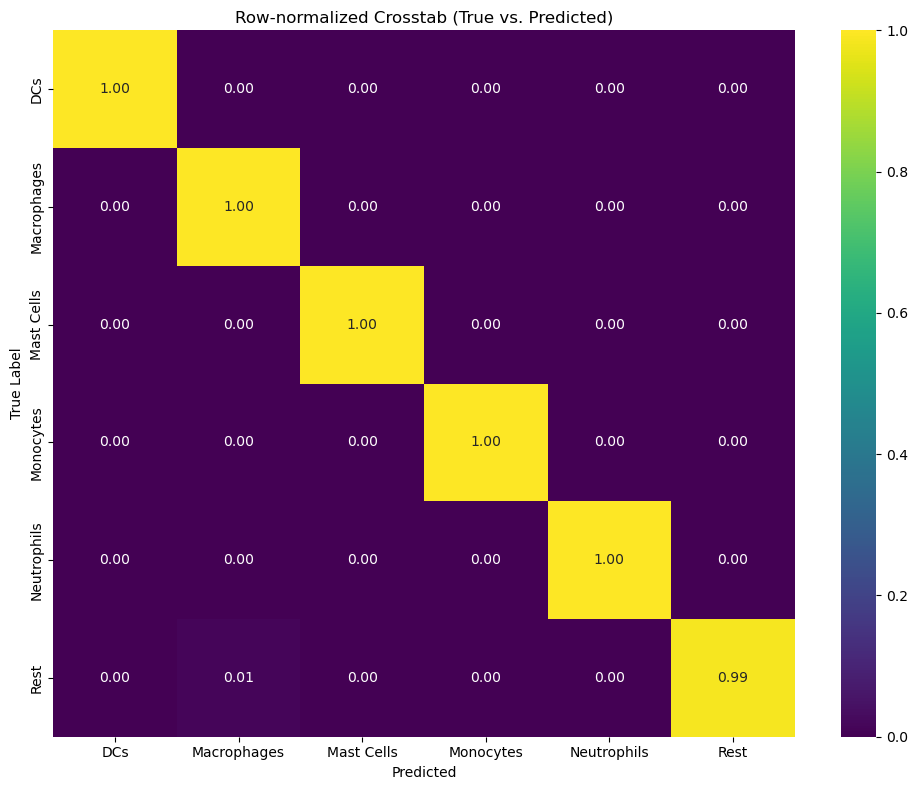

In [19]:
# Row normalize the true labels to show the performance of classification for each class
ct_normalized = pd.crosstab(true_labels, pred_labels, normalize='index')

plt.figure(figsize=(10, 8))
sns.heatmap(ct_normalized, cmap="viridis", annot=True, fmt=".2f")
plt.title("Row-normalized Crosstab (True vs. Predicted)")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()